In [8]:
# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [32]:
class DataExplorer:
    @staticmethod
    def explore_data(data):
        print('Explorando dataset:')
        print(data.head().T)
        print(data.describe())
        print(data.info())
        na = data.isna().mean()*100
        flag = 0
        for i in range(0,len(na)):
            if na.iloc[i] > 0:
                flag = 1
                print('Valores faltantes en: ')
                print(na.iloc[[i]])
        if flag == 0:
            print('No hay valores falntantes.')
            
    @staticmethod
    def plot_histograms(data):
        data.hist(bins=15, figsize=(15, 10))
        plt.show()

    @staticmethod
    def plot_correlation_matrix(data):
        plt.figure(figsize=(50,50))
        sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
        plt.show()
    
    def pca_get(data):
        X = data.iloc[:, :-2]  # Todas las columnas excepto las dos últimas (variables dependientes)
        # Escalado de los datos
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        # Aplicamos PCA
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        # Analizamos la varianza explicada por los componentes principales
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = explained_variance.cumsum()
        # Seleccionamos el número óptimo de componentes (por ejemplo, los que expliquen el 99% de la varianza)
        n_components = next(i for i, cum_var in enumerate(cumulative_variance) if cum_var >= 0.99)
        return n_components

In [22]:
class DataVersioning:
    @staticmethod
    def save(data):
        data.to_csv('../data/processed/residencial_build.csv', index=False)   
        data.to_csv('data.csv', index=False)  
        !git init
        !dvc init -f
        !dvc add data.csv
        !git add data.csv.dvc .gitignore
        !git commit -m "Add data with DVC"
        # Create a directory that will act as the local remote storage
        !mkdir -p local_dvc_storage
        # Configure DVC to use this directory as the remote storage
        !dvc remote add -d local_remote local_dvc_storage
        # Commit the remote storage configuration to Git
        !git add .dvc/config
        !git commit -m "Set up local directory as remote storage"
        !dvc push
        # Remove the dataset and DVC cache
        !rm -rf data.csv
        !rm -rf .dvc/cache
        # Pull the data back from the local remote storage
        !dvc pull
        !dvc add data.csv
        !git add data.csv.dvc
        !git commit -m "Modify Residencial_build dataset"
        !dvc push

In [34]:
class Model:
    def __init__(self, filepath):
        self.filepath = filepath
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4

    def load_data(self):
        self.data = pd.read_excel(self.filepath)
        self.data = self.data.rename(columns=self.data.iloc[0]).drop(self.data.index[0])
        DataExplorer.explore_data(self.data)
        DataVersioning.save(self.data)
        DataExplorer.plot_correlation_matrix(self.data)
        self.nc = DataExplorer.pca_get(self.data)
        return self

    def preprocess_data(self):
        column_names = []

        #Cambiar nombres a variables para evitar tener los mismos nombres.
        for i in range (0, len(self.data.columns)):
            column_names.append(self.data.columns[i])
        for i in range (0, len(self.data.columns)):
            if self.data.columns[i] in column_names:
                column_names[i] = column_names[i] + '_' + str(i)
        self.data.columns = column_names

        #Convertir a variables numéricas
        for col in  self.data.columns:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        #Remover outliners
        for variable in self.data.iloc[:,:-2].columns:
            percentile_10 = self.data[variable].quantile(0.10)
            percentile_90 = self.data[variable].quantile(0.90)
            iqr = percentile_90 - percentile_10
            upper_limit = percentile_90 + 1.5 * iqr
            lower_limit = percentile_10 - 1.5 * iqr
            outliers = self.data[(self.data[variable] < lower_limit) | (self.data[variable] > upper_limit)]
            self.data = self.data[~self.data[variable].isin(outliers[variable])]
        
        #Remover variables altamente correlacionadas
        corr_matrix = self.data.corr().abs()# get upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))# find features with correlation greater than 0.98
        to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]# drop highly correlated features
        self.data.drop(to_drop, axis=1, inplace=True)

        DataVersioning.save(self.data)

        #Dividir el dataset
        X = self.data.iloc[:,:-2]
        Y = self.data.iloc[:,[-2,-1]]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        return self
    
    def pipeline_making(self):
        standar = StandardScaler()
        minmax = MinMaxScaler()
        pca = PCA(n_components=self.nc)
        self.preprocessing = ColumnTransformer([
        ('minmax', minmax, make_column_selector(dtype_include=np.number)),
        ('stan', standar, make_column_selector(dtype_include=np.number)),
        ('pca', pca, make_column_selector(dtype_include=np.number))
        ], remainder = 'passthrough')
        self.model = make_pipeline(self.preprocessing, RandomForestRegressor())
    
    def train_model(self):
        self.model.fit(self.X_train, self.y_train)
        return self
    
    def evaluate_model(self):
        print("Model Evaluation:")
        y_pred = self.model.predict(self.X_test)
        r2_score_ = r2_score(self.y_test, y_pred)
        mean_squared_error_ = mean_squared_error(self.y_test, y_pred)
        print('r2_score: ' + str(r2_score_))
        print('mean_squared_error: ' + str(mean_squared_error_))
        return self

Explorando dataset:
                           1          2           3           4          5
START YEAR                81         84          78          72         87
START QUARTER              1          1           1           2          1
COMPLETION YEAR           85         89          81          73         90
COMPLETION QUARTER         1          4           4           2          2
V-1                        1          1           1           1          1
V-2                     3150       7600        4800         685       3000
V-3                      920       1140         840         202        800
V-4                    598.5       3040         480        13.7       1230
V-5                      190        400         100          20        410
V-6                  1010.84     963.81      689.84      459.54     631.91
V-7                       16         23          15           4         13
V-8                     1200       2900         630         140       5000
V-11 

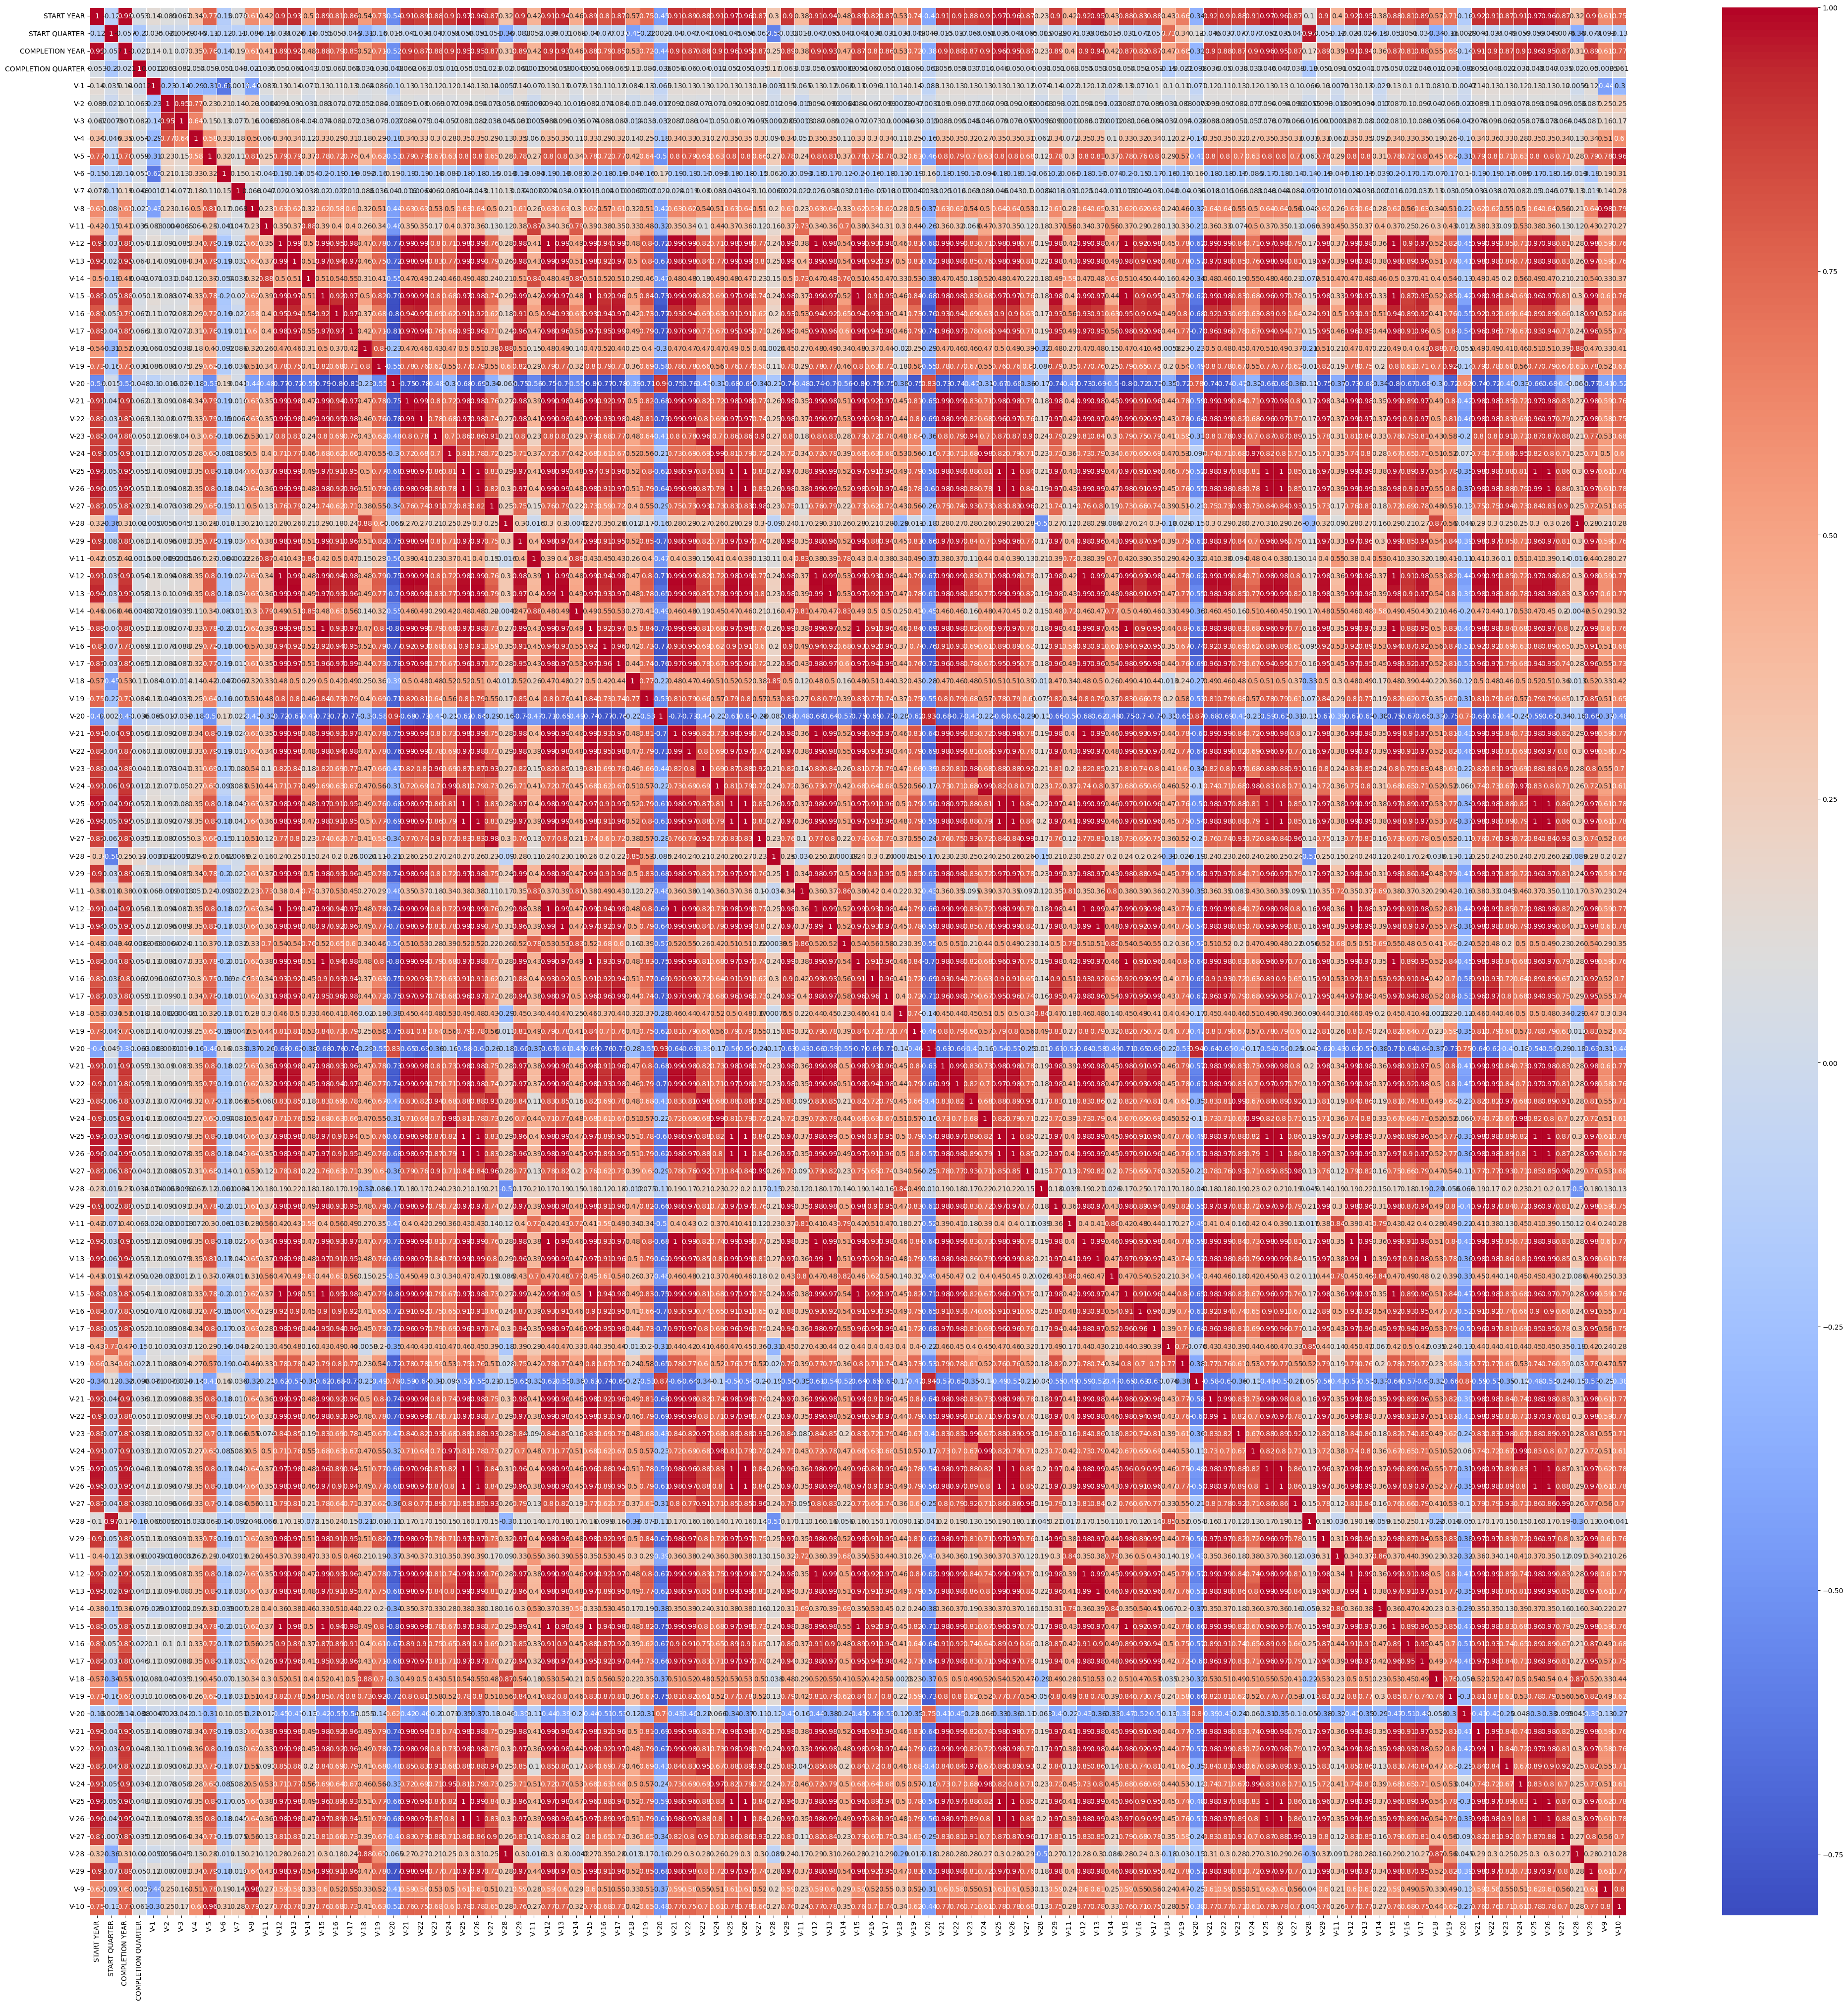

Reinitialized existing Git repository in /Users/juancarloscamperovilla/Documents/GitHub/MLOps/Residencial_build/Fase_1/notebooks/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>
⠋ Checking graph                                       core>
Adding...                                   

['/Users/juancarloscamperovilla/Documents/GitHub/MLOps/Residencial_build/Fase_1/models/model_3.joblib']

In [35]:
filepath='/Users/juancarloscamperovilla/Documents/GitHub/MLOps/Residencial_build/Fase_1/data/raw/Residential-Building-Data-Set.xlsx'

model = Model(filepath)
model.load_data()
model.preprocess_data()
model.pipeline_making()
model.train_model()
model.evaluate_model()
joblib.dump(model, '/Users/juancarloscamperovilla/Documents/GitHub/MLOps/Residencial_build/Fase_1/models/model_3.joblib')